In [1]:
using ResumableFunctions, ConcurrentSim, Plots, Statistics, Distributions

# Scheduling events and setting callbacks

There is a central Simulation object that tracks the timeline

In [2]:
sim = Simulation()

ConcurrentSim.Simulation time: 0.0 active_process: nothing

Now we define an event that we want to put on that timeline

In [3]:
my_evt = Event(sim)

ConcurrentSim.Event 1

Right now the event is not scheduled yet, so it has the state "idle"

In [4]:
state(my_evt)

idle::EVENT_STATE = 0

Now we schedule the event to take place at our favorite time!

In [5]:
ConcurrentSim.schedule(my_evt, 42)

ConcurrentSim.Event 1

This changes the state of the event to "scheduled"

In [6]:
state(my_evt)

scheduled::EVENT_STATE = 1

To actually do something when the event happens, we need to set callback functions.
A callback function should always take the event that triggers it as an argument.

In [7]:
f1(evt) = println("The meaning of life is...")
f2(evt) = println("... $(now(environment(evt)))")

f2 (generic function with 1 method)

Functions are registered as callbacks to events using the @callback macro.

In [8]:
@callback f1(my_evt)
@callback f2(my_evt)

#1 (generic function with 1 method)

Now we run the simulation!

In [9]:
run(sim)

The meaning of life is...
... 42.0


The status of the event has now changed to "processed", as it is in the past now

In [10]:
state(my_evt)

processed::EVENT_STATE = 2

# Processes
Scheduling events and registering callbacks by hand is not the typical worksflow.
It is more idiomatic and more convenient to use "processes" that schedule events,
wait for events, and then do something.
Let'´s rewrite the above example using a process!

The "blueprint" for a process is written as a function with the @resumable macro
in front (this uses the ResumableFunctions.jl package).
It is basically a set of instructions.

In [11]:
@resumable function meaning_of_life(env::Environment)
    my_evt = timeout(env, 42)  # creates an event 42 time units in the future
    @yield my_evt  # waiting for events is done using the @yield macro.
    f1(my_evt); f2(my_evt)
end

meaning_of_life (generic function with 1 method)

Now instantiate a process from this blueprint using the @process macro.

In [12]:
sim = Simulation()
process = @process meaning_of_life(sim)

ConcurrentSim.Process 1

Run the simulation

In [13]:
run(sim)

The meaning of life is...
... 42.0


# We can also wait for multiple events at once!

In [14]:
@resumable function wait_for_multiple_events(env::Environment)
    event_1 = timeout(env, 10)
    event_2 = timeout(env, 20)
    @yield event_1 | event_2  # wait for either to be done
    println("time: $(now(env))")
    event_1 = timeout(env, 100)
    event_2 = timeout(env, 200)
    @yield event_1 & event_2  # wait for all to be done
    println("time: $(now(env))")
    event_1 = timeout(env, 1000)
    event_2 = timeout(env, 2000)
    event_3 = timeout(env, 3000)
    @yield AnyOf(event_1, event_2, event_3)
    println("time: $(now(env))")
    event_1 = timeout(env, 10000)
    event_2 = timeout(env, 20000)
    event_3 = timeout(env, 30000)
    @yield AllOf(event_1, event_2, event_3)
    println("time: $(now(env))")
end

sim = Simulation()
@process wait_for_multiple_events(sim)
run(sim)

time: 10.0
time: 210.0
time: 1210.0
time: 31210.0


# Computing time and matrix time
Some nice things about discrete-event simulation versus real-time simulation include:
- The computing time does not depend on how much time passes in the simulation
("matrix time"). Time is just a number!
- The timing resolution is arbitrary. We can easily track time periods of both
years and nanoseconds in the same simulation!

To drive home the first point, let's do a bit of benchmarking.

Make a simple timer process.

In [15]:
@resumable function timer(env::Environment, time)
    @yield timeout(env, time)
end

timer (generic function with 1 method)

Measure the computational time associated with a certain amount of matrix time.

In [16]:
function time_the_timer(matrix_time)
    sim = Simulation()
    process = @process timer(sim, matrix_time)
    computation_time = @elapsed run(sim, process)
    computation_time
end

time_the_timer (generic function with 1 method)

Function to gather statistics for that

In [17]:
function benchmark_simulation(num_samples)
    matrix_times = logrange(1E-10, 1E10, 1000)
    computation_times = [[time_the_timer(t) for _ in 1:num_samples] for t in matrix_times]
    computation_time_means = mean.(computation_times)
    computation_time_errors = std.(computation_times) / sqrt(num_samples)
    matrix_times, computation_time_means, computation_time_errors
end

benchmark_simulation (generic function with 1 method)

Force compilation to make the results more reliable

In [18]:
benchmark_simulation(1)

(LogRange{Float64}(1.0e-10, 1.0e10, 1000), [0.072949074, 4.808e-5, 2.6442e-5, 2.5297e-5, 2.5344e-5, 2.5022e-5, 2.4972e-5, 2.5105e-5, 2.5044e-5, 2.5072e-5  …  2.5205e-5, 2.5153e-5, 2.5188e-5, 2.5104e-5, 2.5041e-5, 2.4911e-5, 2.5162e-5, 2.5207e-5, 2.5209e-5, 2.5303e-5], [NaN, NaN, NaN, NaN, NaN, NaN, NaN, NaN, NaN, NaN  …  NaN, NaN, NaN, NaN, NaN, NaN, NaN, NaN, NaN, NaN])

Gather some data

In [19]:
matrix_times, computation_time_means, computation_time_errors = benchmark_simulation(100)

(LogRange{Float64}(1.0e-10, 1.0e10, 1000), [2.5276150000000004e-5, 2.5170740000000002e-5, 2.5231179999999995e-5, 2.5100939999999995e-5, 2.5074360000000006e-5, 2.5121239999999995e-5, 2.5241909999999997e-5, 2.608375e-5, 2.535154e-5, 2.522308e-5  …  2.5004889999999998e-5, 2.513256e-5, 2.5124030000000004e-5, 2.4868209999999998e-5, 2.496984e-5, 2.509046e-5, 2.500814e-5, 2.5059289999999995e-5, 2.5034950000000007e-5, 2.5280019999999997e-5], [2.5281432695585394e-7, 7.14812649325936e-8, 9.098793057934173e-8, 6.931092268928762e-8, 7.645580953806724e-8, 7.455355490850152e-8, 9.664970080479589e-8, 2.836916188772804e-7, 1.4056589986928058e-7, 1.0594257228433821e-7  …  4.7161165532071334e-8, 7.793886275326788e-8, 4.3345950272782177e-8, 2.2673841533780504e-8, 5.1674163131622527e-8, 1.0354089751680667e-7, 5.934398613936454e-8, 6.801713434603419e-8, 4.496565777110215e-8, 1.4566970663217192e-7])

Let's inspect!

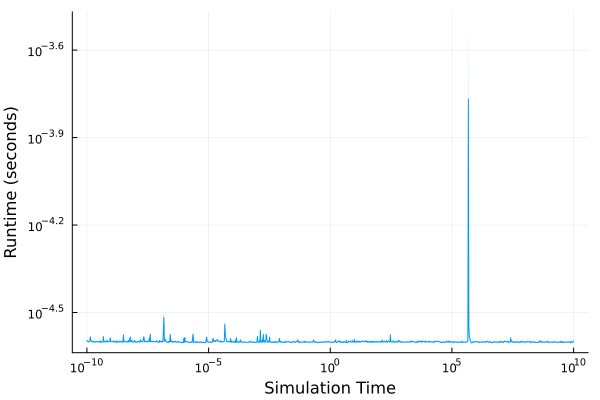

In [20]:
using Plots
plot(matrix_times, computation_time_means, ribbon=computation_time_errors)
plot!(xaxis=:log10, yaxis=:log10, xlabel="Simulation Time", ylabel="Runtime (seconds)",
    legend=false)

# Interactions: ping-pong
To make a simulation that is actually useful, we need to have multiple autonomous
processes that interact with each other, resulting in some emergent dynamics.
One way to make processes interact is by having them "interrupt" each other.
Let's see how we can use that to play ping pong!

A ping-pong player waits until it receives a message, adds its favorite word to the
message, prints it for us, and then sends it back to its partner one time step later.

In [21]:
@resumable function ping_pong_player(env::Environment, favorite_word, partner=nothing)
    while true
        accumulated_message = favorite_word   # the message to be printed
        try
            @yield timeout(env, Inf)  # wait until interrupted
        catch e
            isnothing(partner) && (partner = e.by)  # set partner if not set yet

            isnothing(e.cause) || (accumulated_message = e.cause * favorite_word)
        end
        println("$(now(env)): $accumulated_message")
        @yield timeout(env, 1)
        @yield interrupt(partner, accumulated_message)
    end
end

ping_pong_player (generic function with 2 methods)

At first all ping-pong players are waiting:
we need outside interference to start the game!

In [22]:
@resumable function start_sim(env::Environment, start_player::Process)
    @yield interrupt(start_player)
end

start_sim (generic function with 1 method)

Set up the simulation

In [23]:
sim = Simulation()
bob = @process ping_pong_player(sim, " Pong! ")
alice = @process ping_pong_player(sim, " Ping! ", bob)
starter = @process start_sim(sim, alice)

ConcurrentSim.Process 5

Let's play!

In [24]:
number_of_steps = 10
run(sim, number_of_steps)

0.0:  Ping! 
1.0:  Ping!  Pong! 
2.0:  Ping!  Pong!  Ping! 
3.0:  Ping!  Pong!  Ping!  Pong! 
4.0:  Ping!  Pong!  Ping!  Pong!  Ping! 
5.0:  Ping!  Pong!  Ping!  Pong!  Ping!  Pong! 
6.0:  Ping!  Pong!  Ping!  Pong!  Ping!  Pong!  Ping! 
7.0:  Ping!  Pong!  Ping!  Pong!  Ping!  Pong!  Ping!  Pong! 
8.0:  Ping!  Pong!  Ping!  Pong!  Ping!  Pong!  Ping!  Pong!  Ping! 
9.0:  Ping!  Pong!  Ping!  Pong!  Ping!  Pong!  Ping!  Pong!  Ping!  Pong! 


# Resource Sharing: Shovels

Discrete event simulation really shines in modeling multiple agents that need to share
some scarce resources. ConcurrentSim.jl has a built-in Resource type to help with that
(and other similar types, for example Store).
Let's look at a simple example!

Imagine a group of people want to dig a really deep hole in the beach, but there
are not enough shovels for everyone. Moreover, shoveling is hard work, and after spending
some time shoveling, the workers need to rest for a while and go for a swim.
How much shoveling can they do in a given time period?

We define a Beach structure where we collect state information.

In [25]:
mutable struct Beach
    env::Environment
    shovels::Resource
    amount_shoveled::Float64
    function Beach(env::Environment, shovels::Resource)
        new(env, shovels, 0)
    end
end

Shovelers try to get a shovel, work for some time, and then rest for some time,
until they try to get a shovel again.

In [26]:
@resumable function shoveler(env::Environment, beach::Beach, work_time, rest_time)
    while true
        @yield get(beach.shovels, 1)  # get a shovel or wait until one is available
        @yield timeout(env, work_time)  # work for some time
        beach.amount_shoveled += work_time  # Done! Shoveled one "sand unit" per time unit.
        @yield put!(beach.shovels, 1)  # return the shovel
        @yield timeout(env, rest_time)  # time to take a rest!
    end
end

shoveler (generic function with 1 method)

We now wrap the entire simulation into a function. The function runs the simulation for
a given amount of time, and then returns the total amount of sand shoveled.

In [27]:
function amount_shoveled_after_time(time, num_shovels, num_shovelers,
        amount_work_time, amount_rest_time)
    sim = Simulation()
    shovels = Resource(sim, num_shovels; level=num_shovels)
    beach = Beach(sim, shovels)
    shovelers = [@process shoveler(sim, beach, amount_work_time, amount_rest_time)
        for _ in 1:num_shovelers]
    run(sim, time)
    beach.amount_shoveled
end

amount_shoveled_after_time (generic function with 1 method)

Let's see how the amount of sand shoveled in 1000 time units depends on the number of
shovelers! How many shovelers do we need until the shovels become the limiting factor?

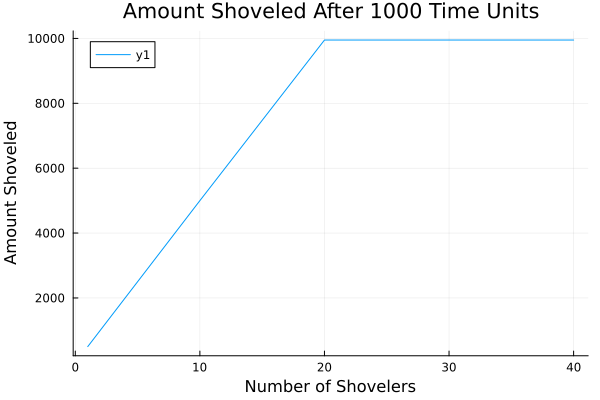

In [28]:
num_shovels = 10
amount_work_time = 5
amount_rest_time = 5

num_shovelers = 1:40
amounts = [amount_shoveled_after_time(1000, num_shovels, n, amount_work_time,
    amount_rest_time) for n in num_shovelers]

plot(num_shovelers, amounts, xlabel="Number of Shovelers", ylabel="Amount Shoveled",
    title="Amount Shoveled After 1000 Time Units")

# Going Shopping
There's another useful built-in resource type: Store.
It is a resource that doesn't just hold a pile of some anonymous resource,
but that instead holds a collection of specific items that can be retrieved.
As an example, let's model some shoppers that go to WholeFoods to buy fruits.

We model two types of fruit being sold.

In [29]:
abstract type Fruit end
struct Apple <: Fruit end
struct Orange <: Fruit end

Shoppers arrive at the store when they get hungry to buy their favorite fruit,
and hang around in case it is out of stock.

In [30]:
@resumable function shopper(env::Environment,
        accepted_fruits::Function,  # filter function: return true for acceptable fruits
        store::Store{Fruit}, snack_time)
    while true
        arrival_time = rand(Normal(snack_time))  # when they get hungry is slightly random
        @yield timeout(env, arrival_time)
        println("$(round(now(env), sigdigits=2)): \
            customer $(active_process(env)) arrived at the store.")
        purchase = get(store, accepted_fruits)
        @yield purchase  # wait until an acceptable fruit is available
        fruit = value(purchase)  # the retrieved item is the value of the event
        println("$(round(now(env), sigdigits=2)): customer $(active_process(env)) bought \
            an $(fruit isa Apple ? "apple 🍎" : "orange 🍊 ").")
    end
end

shopper (generic function with 1 method)

There are also suppliers that periodically deliver a batch of fruit.

In [31]:
@resumable function supplier(env::Environment, fruit::Fruit, store::Store{Fruit},
        supply_amount, supply_time)
    while true
        arrival_time = rand(Normal(supply_time))
        @yield timeout(env, arrival_time)
        for _ in 1:supply_amount # deliver supply
            @yield put!(store, fruit)
        end
        println("$(round(now(env), sigdigits=2)): supplier $(active_process(env)) \
            delivered $supply_amount $(fruit isa Apple ? "apples" : "oranges").")
    end
end

supplier (generic function with 1 method)

Let's configure some customers and suppliers and see what happens!

In [32]:
sim = Simulation()

WholeFoods = Store{Fruit}(sim)

@process shopper(sim, isequal(Apple()), WholeFoods, 10)
@process shopper(sim, isequal(Orange()), WholeFoods, 10)
@process shopper(sim, x -> true, WholeFoods, 5)  # this customer is not picky
@process supplier(sim, Apple(), WholeFoods, 5, 50)
@process supplier(sim, Orange(), WholeFoods, 1, 10)

run(sim, 100)

5.1: customer ConcurrentSim.Process 5 arrived at the store.
8.8: supplier ConcurrentSim.Process 9 delivered 1 oranges.
8.8: customer ConcurrentSim.Process 5 bought an orange 🍊 .
9.4: customer ConcurrentSim.Process 1 arrived at the store.
11.0: customer ConcurrentSim.Process 3 arrived at the store.
13.0: customer ConcurrentSim.Process 5 arrived at the store.
20.0: supplier ConcurrentSim.Process 9 delivered 1 oranges.
20.0: customer ConcurrentSim.Process 3 bought an orange 🍊 .
30.0: supplier ConcurrentSim.Process 9 delivered 1 oranges.
30.0: customer ConcurrentSim.Process 5 bought an orange 🍊 .
32.0: customer ConcurrentSim.Process 3 arrived at the store.
34.0: customer ConcurrentSim.Process 5 arrived at the store.
42.0: supplier ConcurrentSim.Process 9 delivered 1 oranges.
42.0: customer ConcurrentSim.Process 3 bought an orange 🍊 .
49.0: customer ConcurrentSim.Process 1 bought an apple 🍎.
49.0: customer ConcurrentSim.Process 5 bought an apple 🍎.
49.0: supplier ConcurrentSim.Process 7 del

---

*This notebook was generated using [Literate.jl](https://github.com/fredrikekre/Literate.jl).*